# 8. Image Segmentation

I'm not quite convinced that this chapter will prove so useful in remote sensing as it is in ground-based photography, especially considering that the last chapter was a bit of a dud, but I'm willing to be surprised. 

Here's what we'll cover:<ul><li>Hough Transform - circle and line detection</li><li>Thresholding and Otsu's segmentation</li><li>Edges-based / region-based segmentation techniques</li><li>Felzenszwalb, SLIC, Quickshift, and Compact Watershed algorithms</li><li>Active Contours, Morphological Snakes, and GrabCut algorithms</li></ul>

Yeah ... uh ... great.

<img src="./img/giphy.gif">


Anyway, image segmentation is based on the idea that the image is composed of several regions of pixels with like values, and the image can be separated and interpreted by breaking it down into these different regions. This is a stepping stone to more advanced image analysis, as this can simplify the representation of an image in to areas of interest, etc.

As always....

In [1]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.data import astronaut
from skimage.io import imread, imsave
from skimage.color import rgb2gray, gray2rgb, label2rgb
from skimage import data, img_as_float
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries

## Hough Transform: Detecting Lines and Circles

<strong>Hough Transform</strong> is a feature extraction technique that aims to find instances of objects of a certain shape using a <em>voting</em> procedure carreid out in a parameter space. It's usually applied to detect <em>straight</em> lines in an image.

We can represent straight lines using polar parameters (...?) ($\rho \theta$) where $\rho$ is the length of the segment and $\theta$ is the angle between the line and the x axis. To explore these values' parameter space, we create a histogram. Then for these paramters we create a number of non-zero pixels in the image that are close to this line and increment the arrya at the position ($\rho, \theta$) accordingly. As such, each pixel is a vote for a line candidate.

<IPython.core.display.Javascript object>


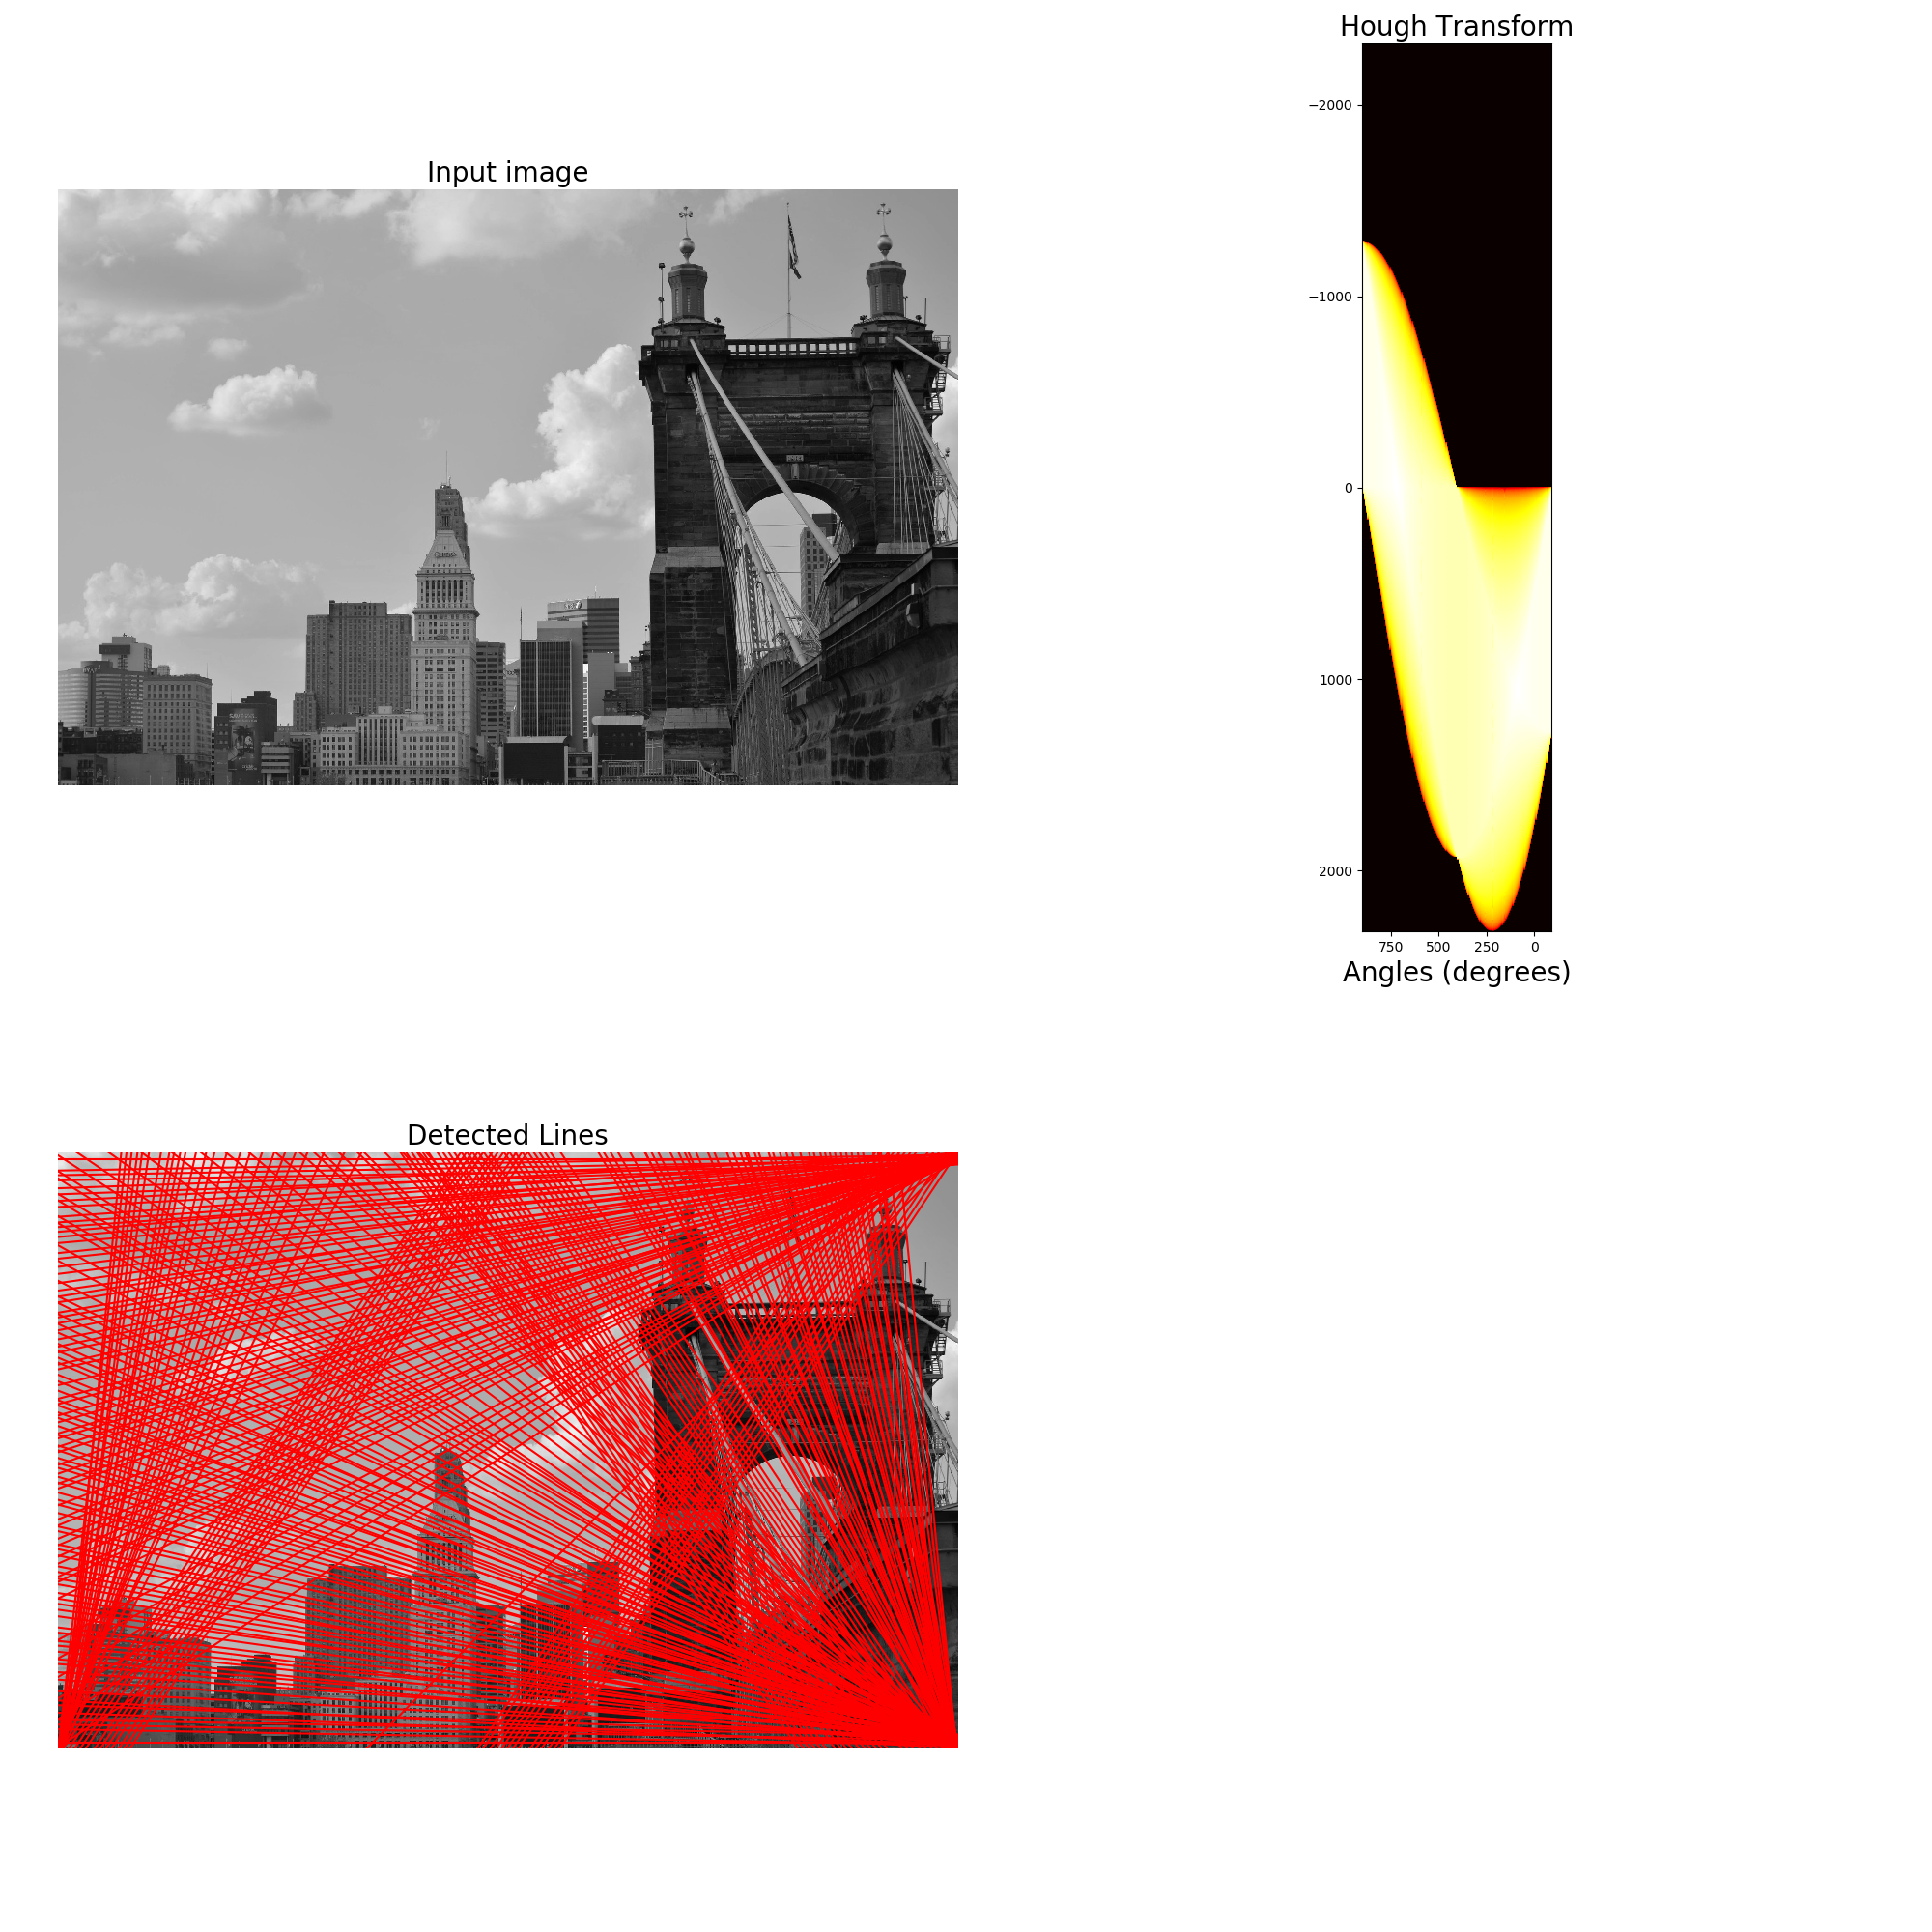

In [7]:
%matplotlib notebook
img = rgb2gray(imread('./img/roebling2.jpeg'))
h, theta, d = hough_line(img)
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()
axes[0].imshow(img, cmap=cm.gray)
axes[0].set_title('Input image', size=20)
axes[0].set_axis_off()
axes[1].imshow(np.log(1 + h), extent=[10*np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
              cmap=cm.hot, aspect=1/1.5)
axes[1].set_title('Hough Transform', size=20)
axes[1].set_xlabel('Angles (degrees)', size=20)
axes[1].axis('image')
axes[2].imshow(img, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)
    axes[2].plot((0, img.shape[1]), (y0, y1), '-r')
axes[2].set_xlim((0, img.shape[1]))
axes[2].set_ylim((img.shape[0], 0))
axes[2].set_axis_off()
axes[2].set_title("Detected Lines", size=20)

plt.tight_layout()
plt.axis('off')
plt.show()

Nope - big fail there

<img src="./img/tears.gif" />

### Thresholding & Otsu's Segmentation

<strong> Thresholding</strong> refers to a process of creating a binary image from a grayscale one, using a pixel value as, well, the threshold. This is a simple way to segment objects from background. We can choose this manually by examining the histogram of pixel values (Otsu's method), or by using an algorithm to decide.

Scikit-image provides a histogram-based and a local (using neighboring pixels) method of providing threshold values. 

<IPython.core.display.Javascript object>


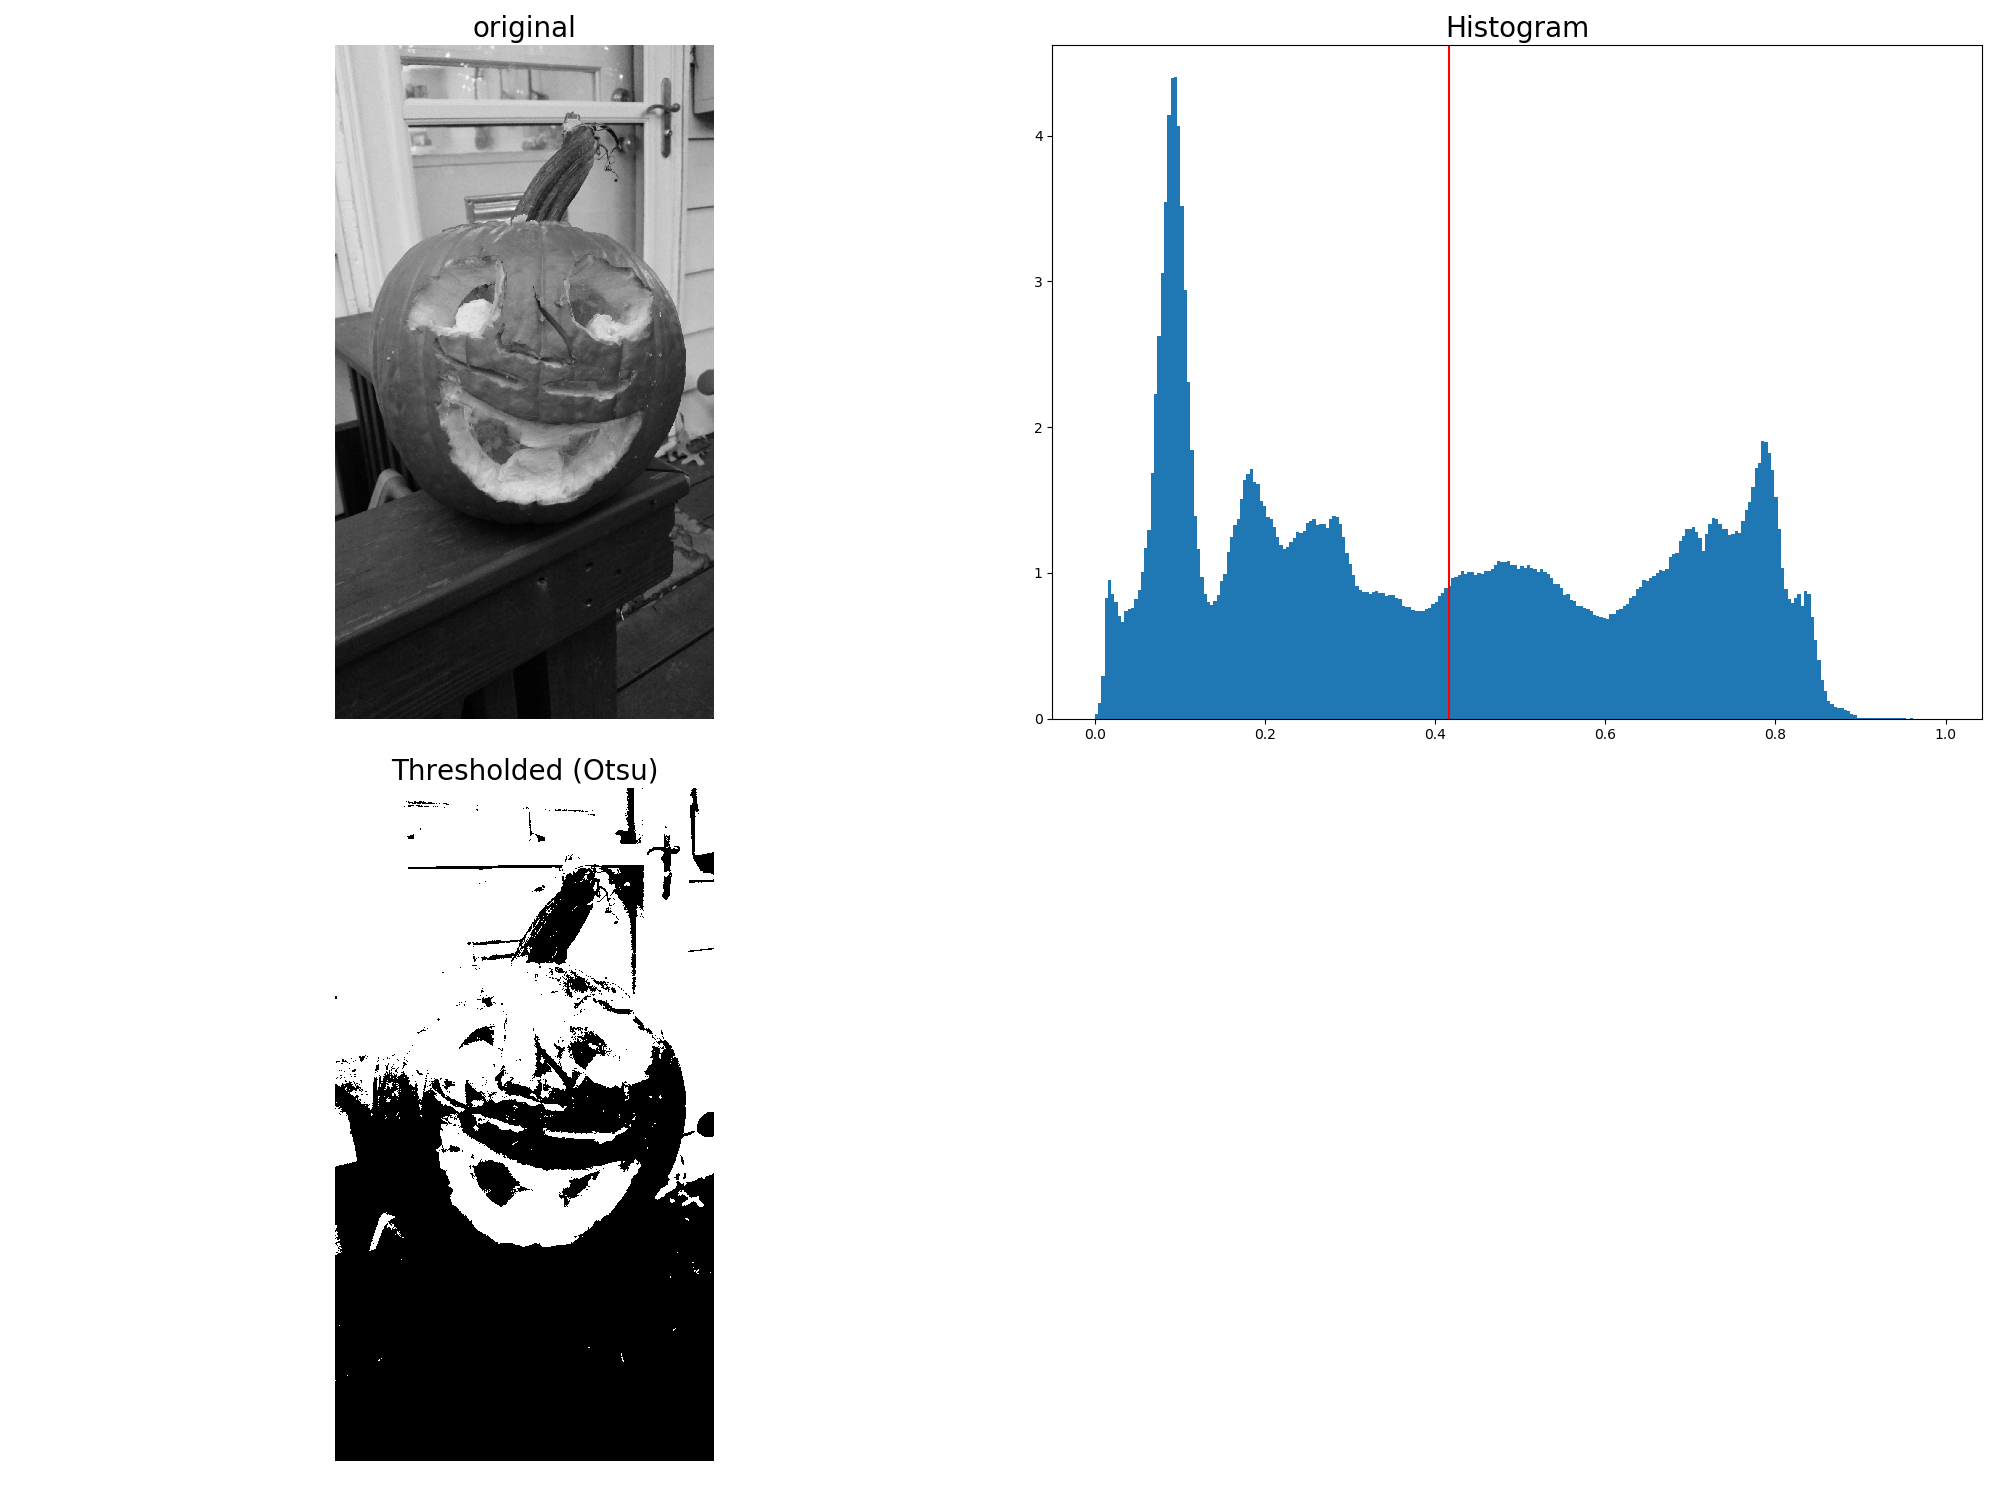

In [28]:
img = rgb2gray(imread('./img/pumpkin.jpg'))
thresh = threshold_otsu(img)
binary = img > thresh

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
ax = ax.ravel()
ax[0], ax[1] = plt.subplot(2, 2, 1), plt.subplot(2, 2, 2)
ax[2] = plt.subplot(2, 2, 3, sharex=ax[0], sharey=ax[0])
ax[3] = plt.subplot(2, 2, 4, sharex=ax[0], sharey=ax[0])
ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title("original", size=20)
ax[0].axis('off')
ax[1].hist(img.ravel(), bins=256, normed=True)
ax[1].set_title('Histogram', size=20)
ax[1].axvline(thresh, color='r')
ax[2].imshow(binary, cmap=cm.gray)
ax[2].set_title('Thresholded (Otsu)', size=20)
ax[2].axis('off')
ax[3].axis('off')
plt.tight_layout()
plt.show()

## Edge- / Region-based Segmentation


/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


<IPython.core.display.Javascript object>


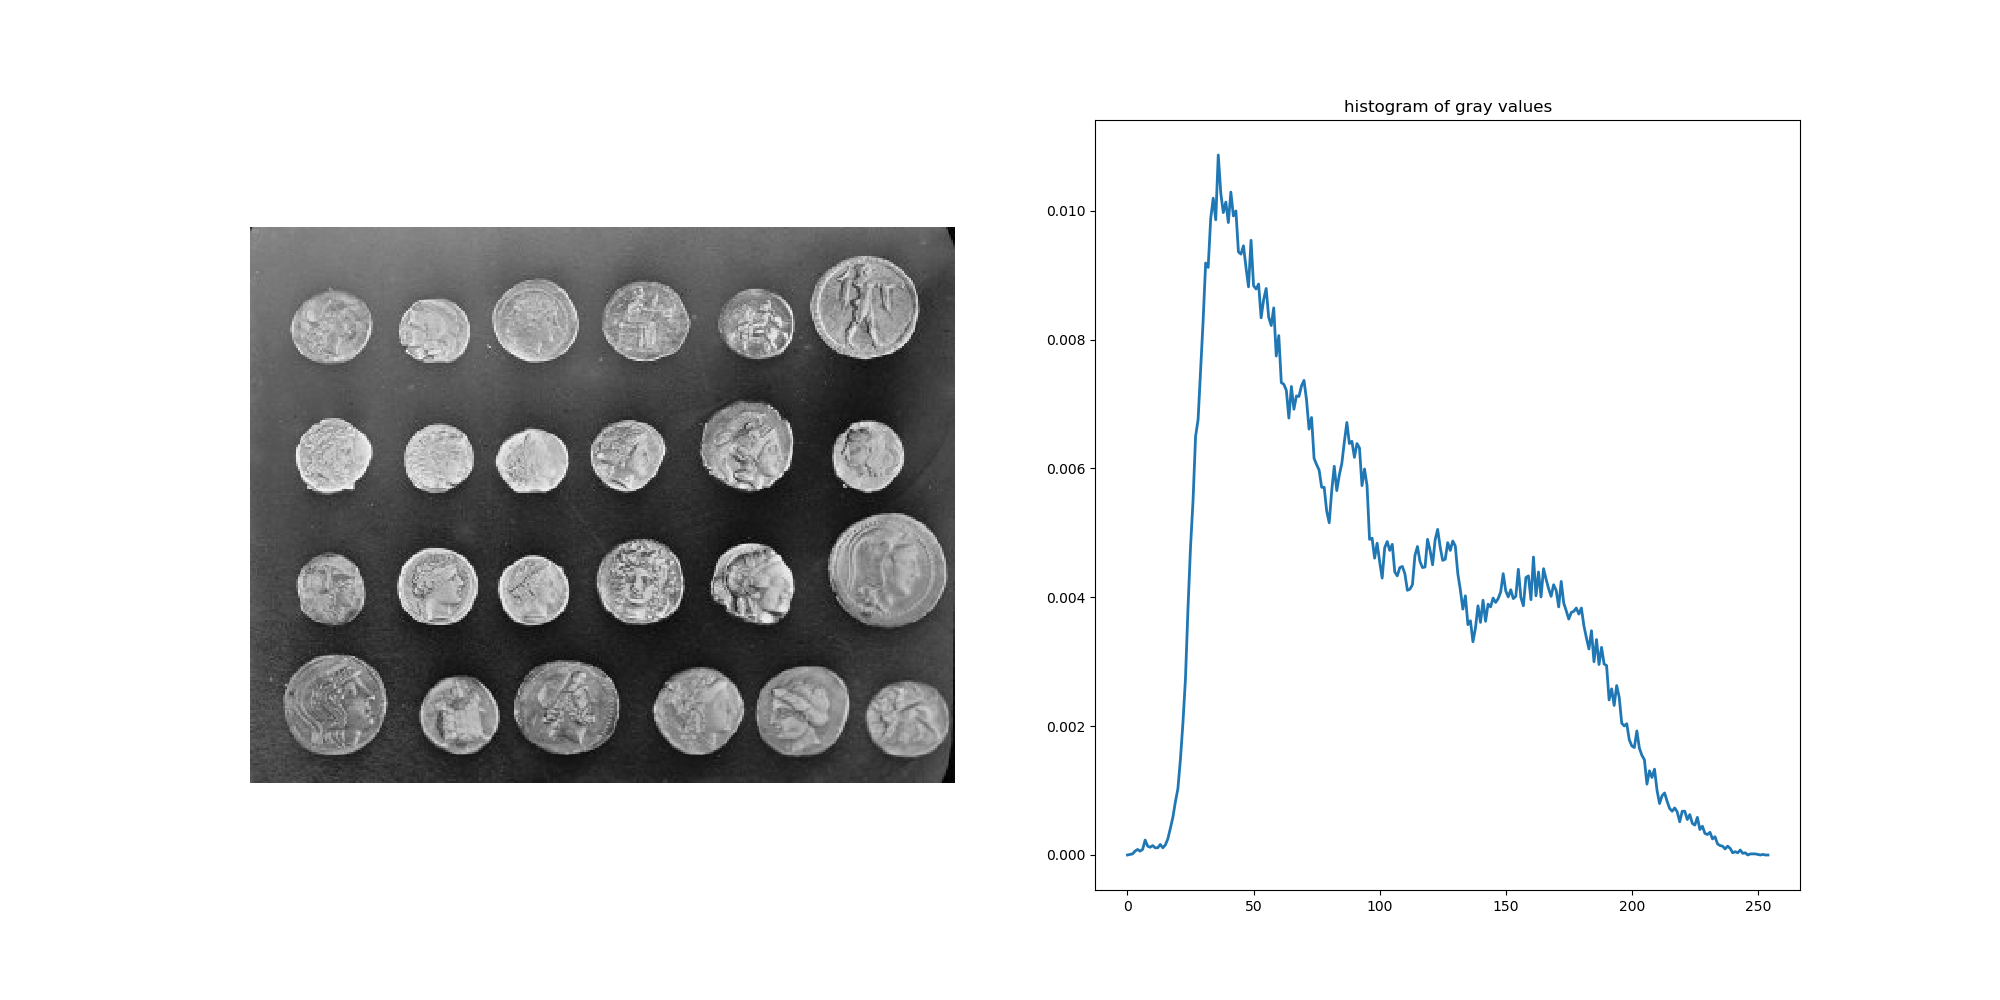

In [29]:
coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256), normed=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
ax[0].axis('off')
ax[1].plot(hist[1][:-1], hist[0], lw=2)
ax[1].set_title('histogram of gray values')
plt.show()

<IPython.core.display.Javascript object>


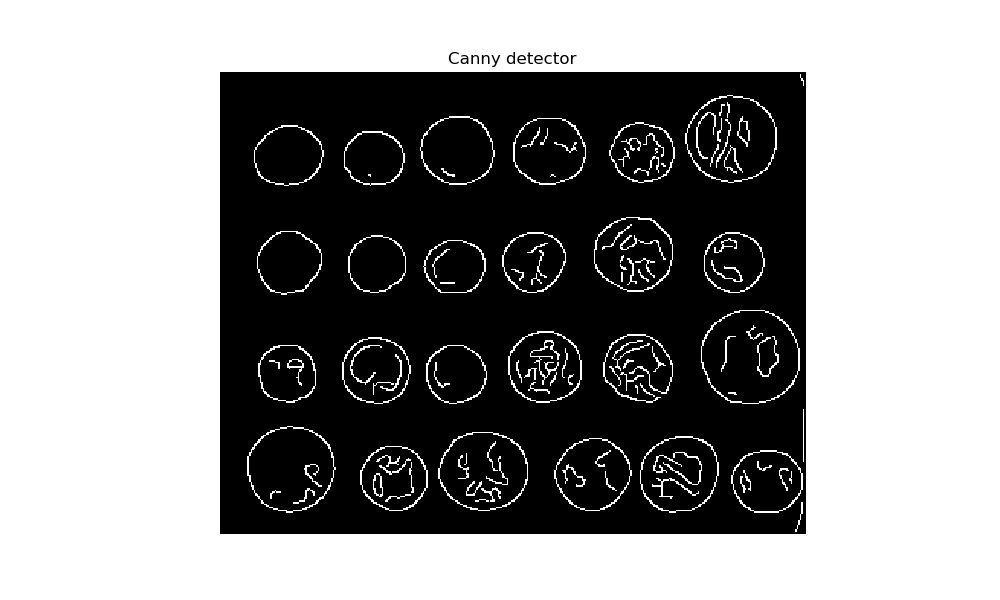

(Text(0.5,1,'Canny detector'), (-0.5, 383.5, 302.5, -0.5), None)

In [32]:
edges = canny(coins, sigma=2)
fig, axes = plt.subplots(figsize=(10, 6))
axes.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
axes.set_title('Canny detector'), axes.axis('off'), plt.show()

<IPython.core.display.Javascript object>


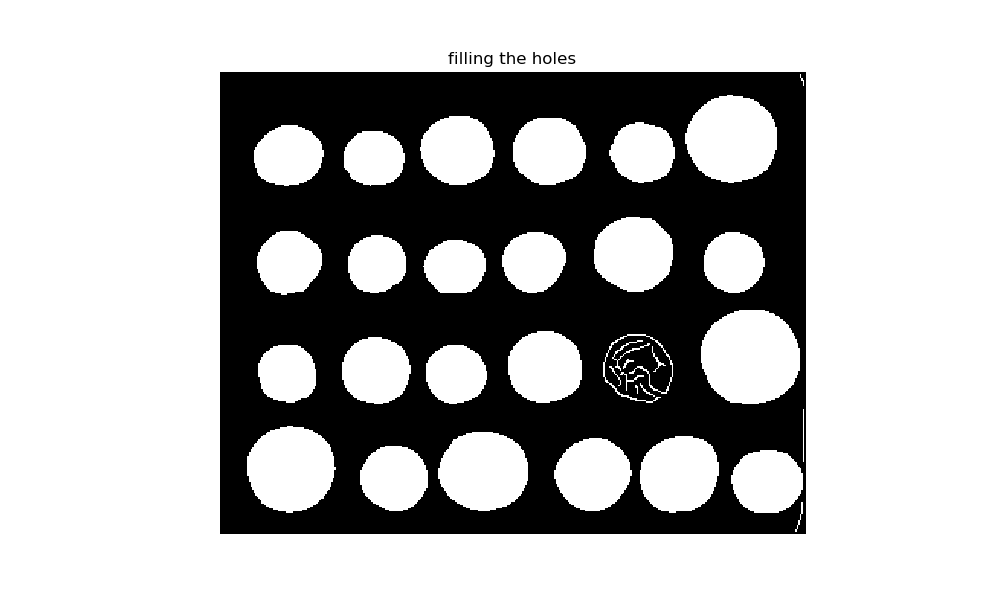

(Text(0.5,1,'filling the holes'), (-0.5, 383.5, 302.5, -0.5), None)

In [33]:
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(edges)
fig, axes = plt.subplots(figsize=(10, 6))
axes.imshow(fill_coins, cmap=plt.cm.gray, interpolation='nearest')
axes.set_title('filling the holes'), axes.axis('off'), plt.show()

<IPython.core.display.Javascript object>


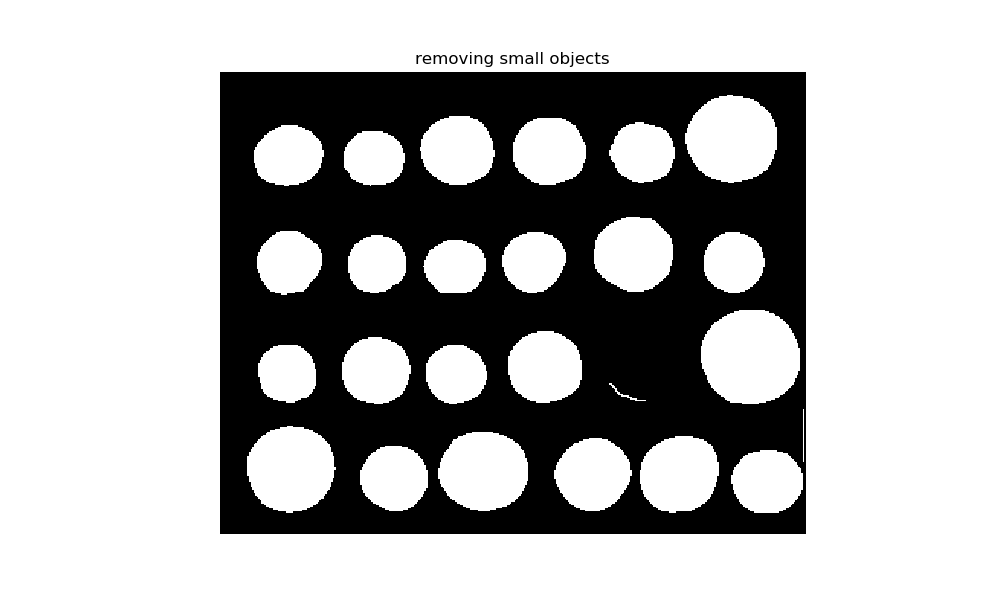

(Text(0.5,1,'removing small objects'), (-0.5, 383.5, 302.5, -0.5), None)

In [34]:
from skimage import morphology
coins_cleaned = morphology.remove_small_objects(fill_coins, 21)
fig, axes = plt.subplots(figsize=(10, 6))
axes.imshow(coins_cleaned, cmap=plt.cm.gray, interpolation='nearest')
axes.set_title('removing small objects'), axes.axis('off'), plt.show()

### Region-Based Segmentation

We'll take the image-to-geography bit in reverse here, as we apply a <strong>watershed</strong> algorithm to segmentation. It's possible in this approach to over-segment the image, & so we make use of a few parameters to adjust for this.

<IPython.core.display.Javascript object>


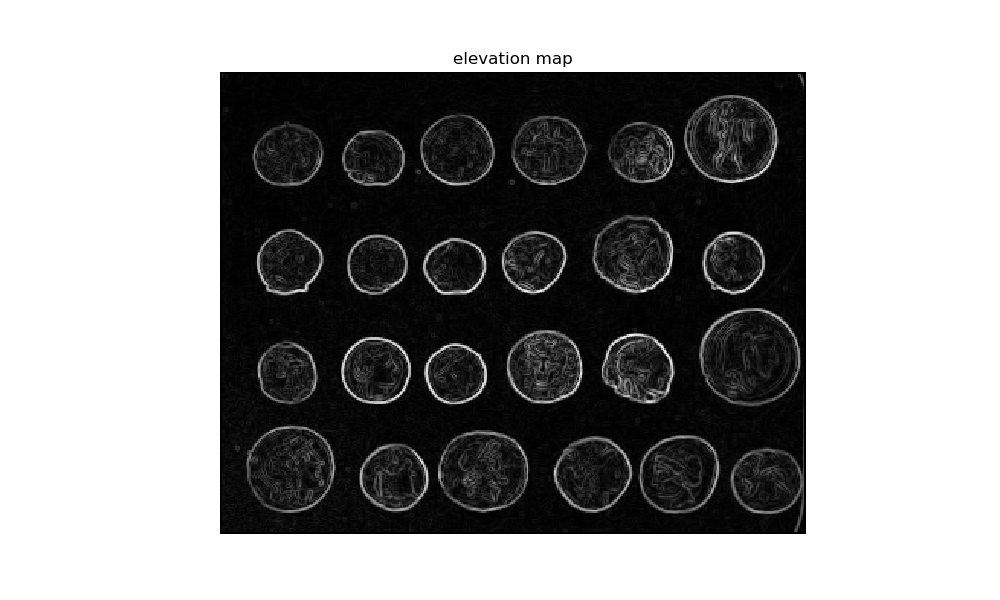

In [36]:
elevation_map = sobel(coins)
fig, axes = plt.subplots(figsize=(10, 6))
axes.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
axes.set_title('elevation map')
axes.axis('off')
plt.show()

2 0


<IPython.core.display.Javascript object>


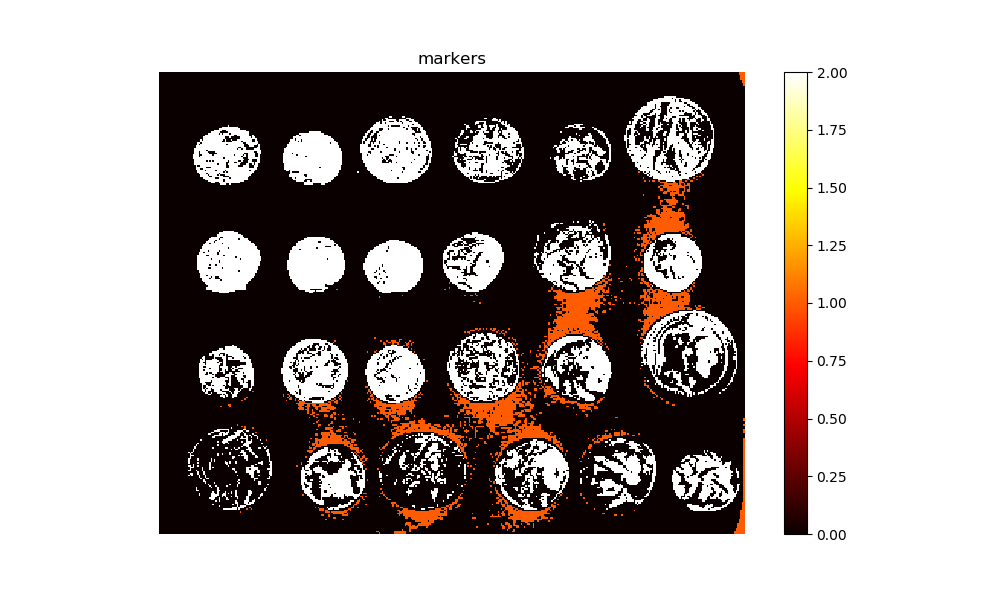

In [37]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2
print(np.max(markers), np.min(markers))
fig, axes = plt.subplots(figsize=(10, 6))
a = axes.imshow(markers, cmap=plt.cm.hot, interpolation='nearest')
plt.colorbar(a)
axes.set_title('markers'), axes.axis('off')
plt.show()

<IPython.core.display.Javascript object>


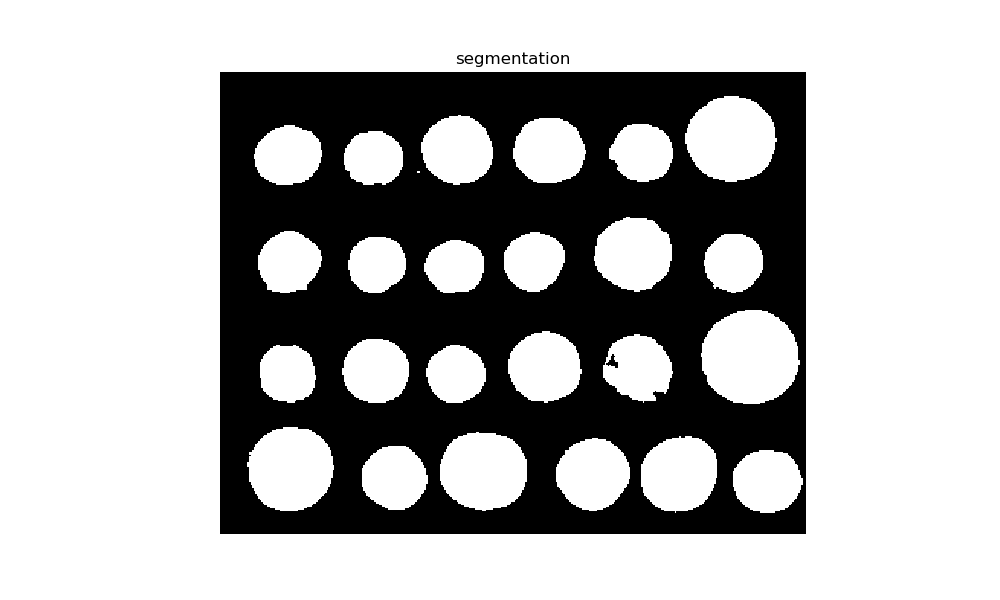

In [38]:
segmentation = morphology.watershed(elevation_map, markers)
fig, axes = plt.subplots(figsize=(10, 6))
axes.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
axes.set_title('segmentation')
axes.axis('off')
plt.show()

<IPython.core.display.Javascript object>


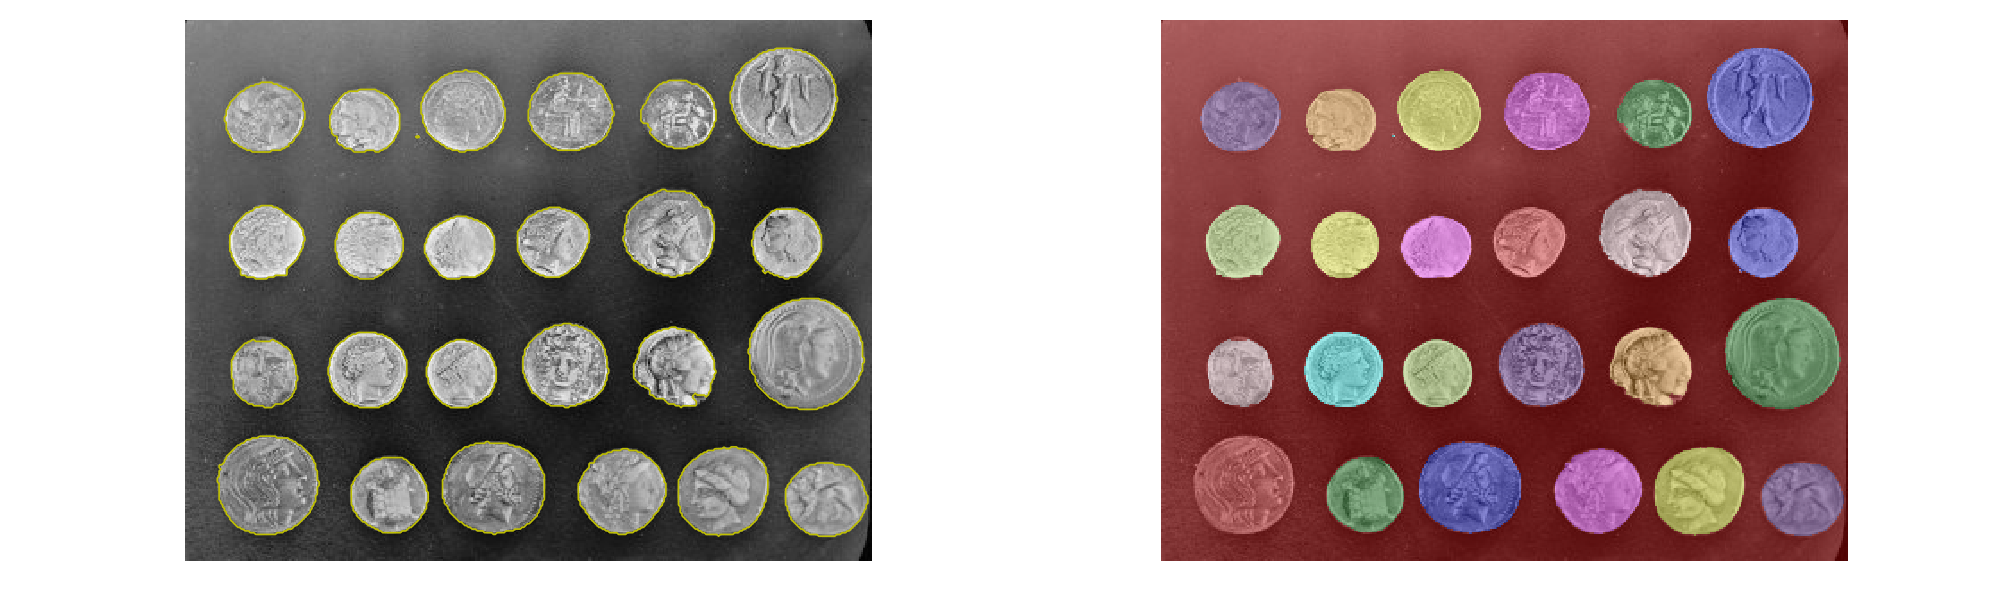

In [39]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')
for a in axes:
    a.axis('off')
plt.tight_layout()
plt.show()

## More Algorithms

### Felzenszwalb

This algorithm takes a graph-based (go, Ty!) approach to segmentation. First, it creates an undirected graph with the pixels as vertices adn the weight of an edge between two vertices being a measure of dissimilarity (e.g., contrast in value). This approach means that as we find image segments, we find connected components in a constructed graph. Edges between two vertices in the same component (region) should have relatively low weights, while edges between vertices in different components will have higher weights.

By doing this we can preserve detail in low-variability regions, but ignore details in high-variability (mixed) regions. We can also adjust the size of segments we want to create via a parameter to the function. The absolute number of segments depends on the local contrast of the image.  Let's code it up in scikit-image:

no - this has crashed on me 2x

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
img = img_as_float(imread('./img/jellyfish.jpg'))
plt.figure(figsize=(8, 10))
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=400)
borders=find_boundaries(segments_fz)
unique_colors = np.unique(segments_fz.ravel())
segments_fz[borders] = -1
colors = [np.zeros(3)]
for color in unique_colors:
    colors.append(np.mean(img[segments_fz == color], axis=0))
    cm = LinearSegmentedColormap.from_list('pallette', colors, N=len(colors))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('original', size=20)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(segments_fz, cmap=cm)
    plt.title('Segmented', size=20)
    plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### SLIC

This is a method that performs k-means clustering  in the color space and image location. 

In [2]:
img = img_as_float(imread('./img/jellyfish.jpg'))
img.shape

(2271, 1280, 3)

In [6]:
def plot_image(img, title):
    plt.imshow(img)
    plt.title(title, size=20)
    plt.axis('off') 

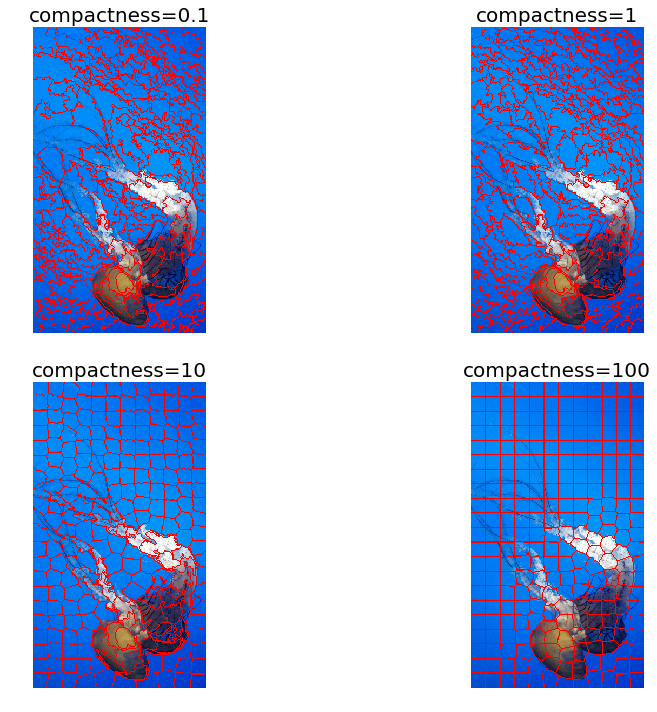

In [7]:
img = img[::2, ::2, :3]
plt.figure(figsize=(15, 10))
i = 1
for compactness in [0.1, 1, 10, 100]:
    plt.subplot(2, 2, i)
    segments_slic = slic(img, n_segments=250, compactness=compactness, sigma=1)
    plot_image(mark_boundaries(img, segments_slic, color=(1, 0, 0)), 'compactness=' + str(compactness))
    i += 1
plt.tight_layout()
plt.show()

### RAG Merging

The <strong>Region Adjacency Graph</strong> can combine over-segmented regions, using SLIC to segment the input image and then construct a RAG to merge the over-segmented regions that are similar in color. Regions are continuously merged until only highly differentiated regions remain.

In [8]:
from skimage import segmentation
from skimage.future import graph

In [12]:
def _weight_mean_color(graph, src, dst, n):
    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight' : diff}
def merge_mean_color(graphc, src, dst):
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] += (graph.node[dst]['total color'] / graph.node[dst]['pixel count'])
    
img = imread('./img/Uli.jpg')
labels = segmentation.slic(img, compactness=30, n_segments=400)
g = graph.rag_mean_color(img, labels)
labels2 = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False, in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
out = label2rgb(labels2, img, kind='avg')
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(out)
plt.axis('off')
plt.tight_layout()
plt.show()

AttributeError: module 'skimage.future.graph' has no attribute 'node'

Nope. Doesn't work. Really racking these up today.... Enough so that I am going to just move on to the next section, since this copying from the documentation sort of "writing" reveals that the docs are wrong too. Take that, Van der Walt!

### 